# Emotional Classification Speech Processing
## Project Overview


This project aims to build an end-to-end audio emotion recognition system that accurately classifies human emotions from speech signals. Leveraging machine learning techniques and audio signal processing (like MFCC feature extraction), the model identifies emotional states such as happiness, anger, sadness, etc., from input speech.

The system is trained on a labeled audio dataset and evaluated using performance metrics like confusion matrix, F1-score, and class-wise accuracy. A trained model is exported for real-time testing through a Python script and a deployed Streamlit-based web application, where users can upload audio files and receive instant emotion predictions.

# Installing and loading libraries

In [1]:
!pip install xgboost

In [2]:
!pip install streamlit

In [ ]:
import librosa
import soundfile as sf
import random
import pickle

import numpy as np
import os
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Dataset description
Here we using the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS), which contains emotional speech recordings from 24 professional actors (12 male, 12 female) across 8 emotions. Each audio clip is labeled and follows a structured naming convention for emotion, intensity, and actor identity.

This **Audio_song** folder contains pre-labeled audio files of **human song** with different emotional tones such as happy, sad, angry, neutral, etc. 

In [4]:
Audio_song= r"C:\Users\Megha Agrawal\Downloads\Audio_Song_Actors_01-24"

This **Audio_speech** folder contains pre-labeled audio files of **human speech** with different emotional tones such as happy, sad, angry, neutral, etc. 

In [5]:
Audio_speech=r"C:\Users\Megha Agrawal\Downloads\Audio_Speech_Actors_01-24"

 To confirm that the dataset is loaded correctly, I iterated through the `Audio_song` folder to view a sample actor directory and one `.wav` file inside it. This ensured that the audio data is properly organized before preprocessing.


In [6]:
for actor in os.listdir(Audio_song):
    actor_path = os.path.join(Audio_song, actor)
    print("🎭 Actor folder:", actor_path)
    for file in os.listdir(actor_path):
        
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            print("🎧 Audio file:", file_path)
        break
    break

🎭 Actor folder: C:\Users\Megha Agrawal\Downloads\Audio_Song_Actors_01-24\Actor_01
🎧 Audio file: C:\Users\Megha Agrawal\Downloads\Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav


# Data preprocessing and Analysis

To facilitate interpretability, I first defined a mapping between the **numeric emotion codes embedded in the filenames and their corresponding human-readable emotion labels**.

In [12]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


The `extract_emotion` function extracts the emotion label from the filename using the pre-defined emotion_map.

In [13]:
def extract_emotion(filename):
    parts = filename.split("-")
    emotion_code = parts[2]
    return emotion_map.get(emotion_code, "unknown")

In [14]:
emotion_counts = Counter()
for actor in os.listdir(Audio_speech):
    actor_path = os.path.join(Audio_speech, actor)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion = extract_emotion(file)
            emotion_counts[emotion] += 1
emotion_counts

Counter({'neutral': 96,
         'calm': 192,
         'happy': 192,
         'sad': 192,
         'angry': 192,
         'fearful': 192,
         'disgust': 192,
         'surprised': 192})

- The speech dataset contains **8 emotion classes**.
- All classes (except `neutral`) are evenly distributed with **192 samples each**.
- `neutral` has only **96 samples**, making it a relatively underrepresented class in this dataset.


In [15]:
emotion_counts = Counter()
for actor in os.listdir(Audio_song):
    actor_path = os.path.join(Audio_song, actor)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion = extract_emotion(file)
            emotion_counts[emotion] += 1
emotion_counts

Counter({'neutral': 92,
         'calm': 184,
         'happy': 184,
         'sad': 184,
         'angry': 184,
         'fearful': 184})

- The song dataset includes only **6 emotion categories**.
- Notably, `disgust` and `surprised` are **missing** from this dataset.
- Similar to speech, all emotions except `neutral` are evenly represented with **184 samples each**.
- `neutral` again has slightly fewer samples (**92**), maintaining a pattern seen in the speech dataset.


# Feature Extraction and Label Assignment 

The `extract_features` function plays a crucial role in transforming raw audio signals into structured numerical representations that can be fed into machine learning models.<br> It loads the audio file and extracts:

1)MFCC: Captures timbral texture (important for speech)

2)Chroma: Represents the pitch class content

3)Spectral Contrast: Describes the difference in spectral peaks and valleys

4)Spectral Centroid: Indicates where the “center of mass” of the spectrum is located

These features are combined into a single feature vector using **np.hstack**.


In [16]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)

    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = np.mean(mfcc_feat.T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
    return np.hstack([mfcc,  chroma, contrast, centroid])

In [17]:
X, y = [], []

def process_folder(path):
    count = 0
    for actor in os.listdir(path):
        actor_folder = os.path.join(path, actor)
        if os.path.isdir(actor_folder):
            for file in os.listdir(actor_folder):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_folder, file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(extract_emotion(file))
                        count += 1
                        if count % 50 == 0:
                            print(f"Processed {count} files")
    print(f"Done: Processed total {count} files from {path}")

process_folder(Audio_song)
process_folder(Audio_speech)

Processed 50 files
Processed 100 files
Processed 150 files
Processed 200 files
Processed 250 files
Processed 300 files
Processed 350 files
Processed 400 files
Processed 450 files
Processed 500 files
Processed 550 files
Processed 600 files
Processed 650 files
Processed 700 files
Processed 750 files
Processed 800 files
Processed 850 files
Processed 900 files
Processed 950 files
Processed 1000 files
Done: Processed total 1012 files from C:\Users\Megha Agrawal\Downloads\Audio_Song_Actors_01-24
Processed 50 files
Processed 100 files
Processed 150 files
Processed 200 files
Processed 250 files
Processed 300 files
Processed 350 files
Processed 400 files
Processed 450 files
Processed 500 files
Processed 550 files
Processed 600 files
Processed 650 files
Processed 700 files
Processed 750 files
Processed 800 files
Processed 850 files
Processed 900 files
Processed 950 files
Processed 1000 files
Processed 1050 files
Processed 1100 files
Processed 1150 files
Processed 1200 files
Processed 1250 files


In this step i processed the Audio_speech and Audio_song folder.

# Exploratory Data Analysis

## Checking Class Imbalance in Combined Dataset

In [58]:
label_counts = Counter(y)
print(label_counts)

Counter({'calm': 376, 'happy': 376, 'sad': 376, 'angry': 376, 'fearful': 376, 'disgust': 192, 'surprised': 192, 'neutral': 188})


The dataset is imbalanced — disgust, surprised, and neutral have fewer samples.This imbalance occurs because the song dataset lacks disgust and surprised, and contains fewer neutral samples.

To address this, I will be using **SMOTE** to oversample the minority classes and balance the training data.

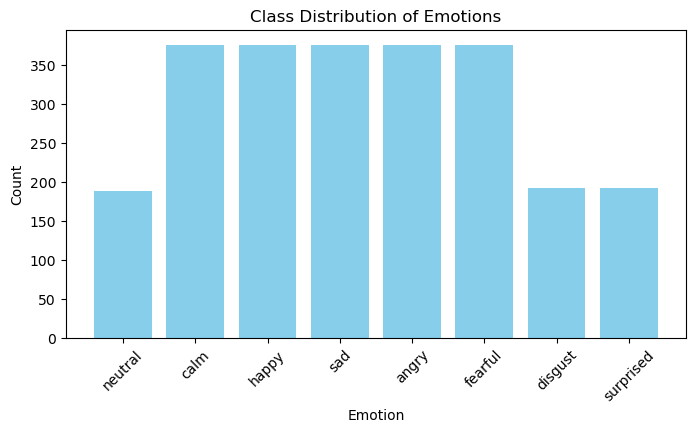

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Class Distribution of Emotions")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Waveform visualisation of different Emotions 

To better understand how emotions differ acoustically, I visualised **raw waveforms** of audio samples from each class. This gives insight into how energy, pitch, and temporal dynamics vary across different emotions.



In [22]:
def plot_waveform_by_emotion(emotion_label, dataset_path, samples=1):
    print(f"\n Waveform for emotion: {emotion_label}")
    count = 0
    for actor in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor)
        for file in os.listdir(actor_path):
            if file.endswith(".wav") and extract_emotion(file) == emotion_label:
                file_path = os.path.join(actor_path, file)
                y, sr = librosa.load(file_path)
                plt.figure(figsize=(10, 3))
                librosa.display.waveshow(y, sr=sr)
                plt.title(f"{emotion_label.capitalize()} - {file}")
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
                count += 1
                if count >= samples:
                    return


 Waveform for emotion: angry


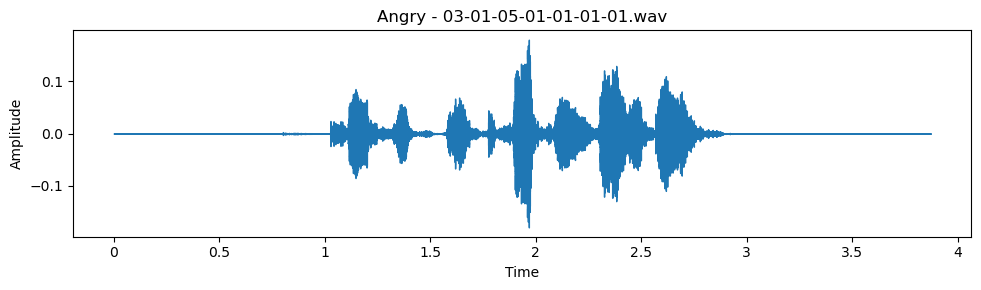

In [23]:
plot_waveform_by_emotion("angry", Audio_speech)


 Waveform for emotion: angry


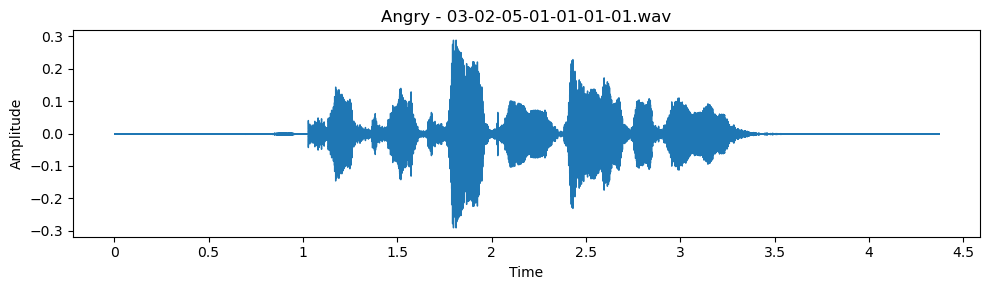

In [24]:
plot_waveform_by_emotion("angry", Audio_song)


 Waveform for emotion: happy


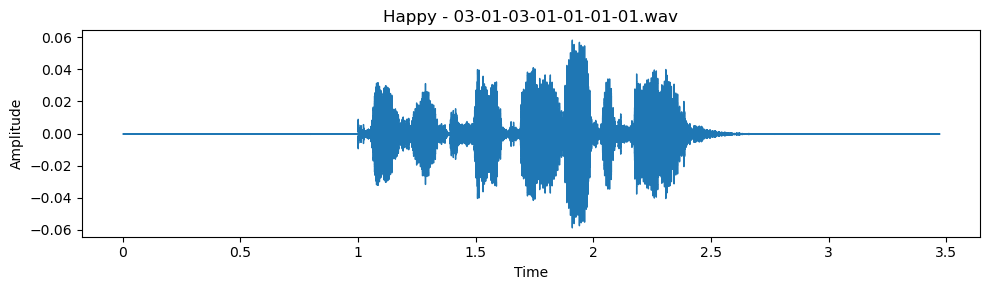

In [25]:
plot_waveform_by_emotion("happy", Audio_speech)


 Waveform for emotion: happy


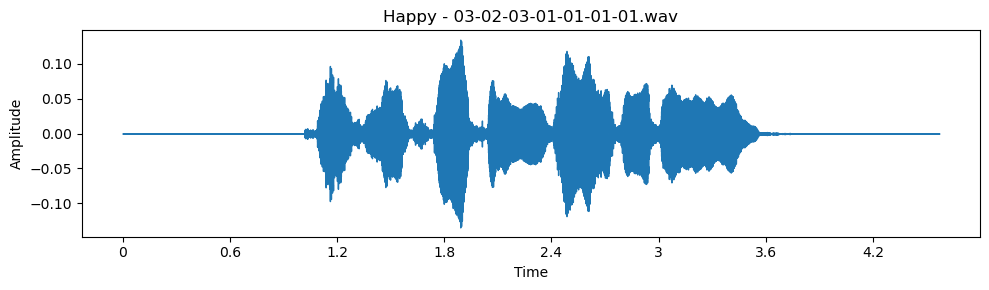

In [26]:
plot_waveform_by_emotion("happy", Audio_song)


 Waveform for emotion: neutral


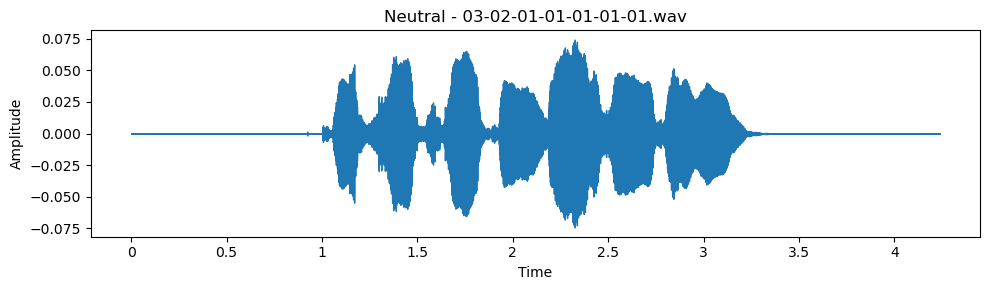

In [27]:
plot_waveform_by_emotion("neutral", Audio_song)


 Waveform for emotion: neutral


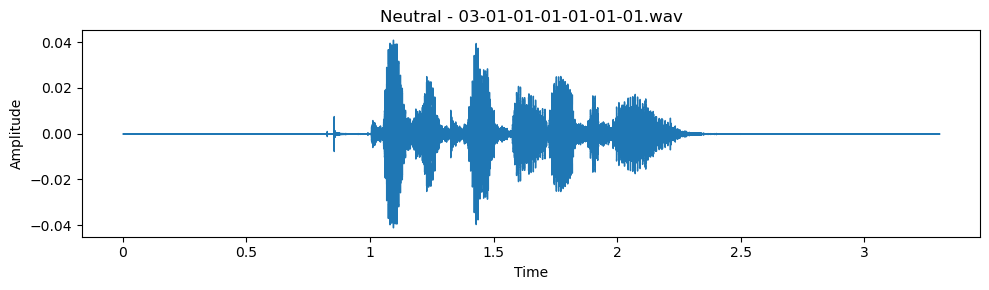

In [28]:
plot_waveform_by_emotion("neutral", Audio_speech)


 Waveform for emotion: fearful


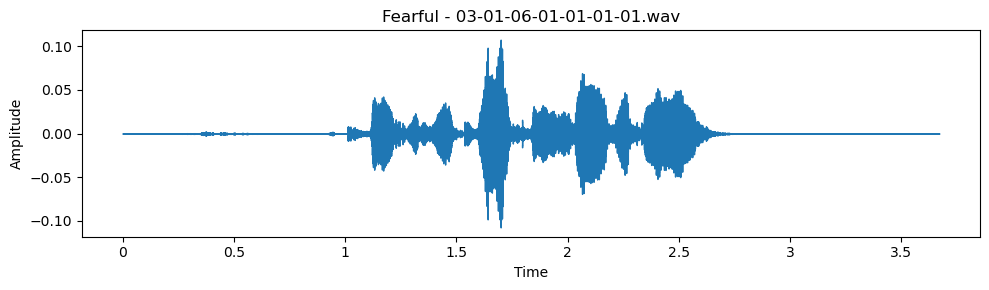

In [29]:
plot_waveform_by_emotion("fearful", Audio_speech)


 Waveform for emotion: disgust


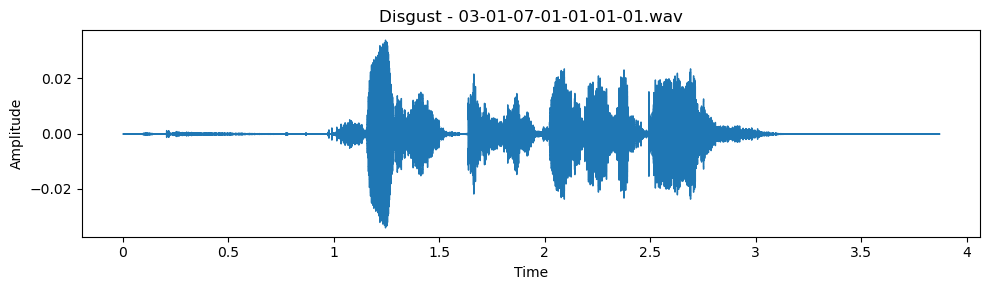

In [30]:
plot_waveform_by_emotion("disgust", Audio_speech)


 Waveform for emotion: surprised


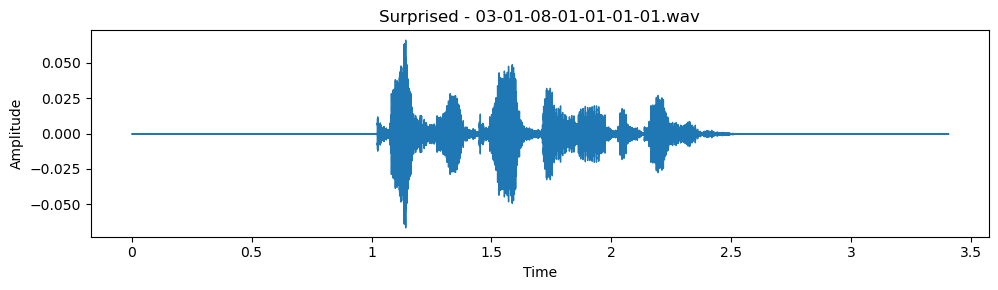

In [31]:
plot_waveform_by_emotion("surprised", Audio_speech)


 Waveform for emotion: calm


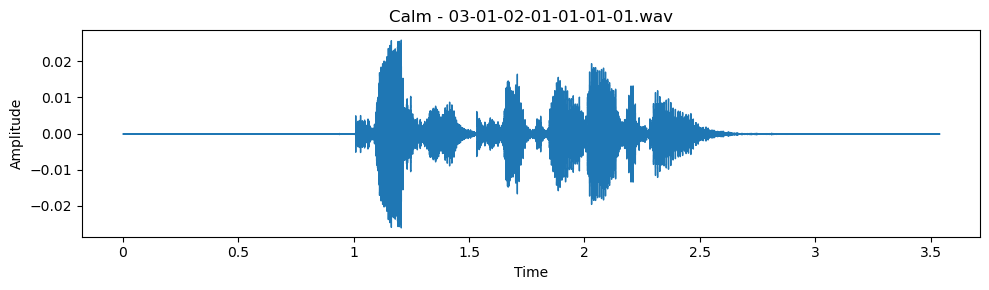

In [32]:
plot_waveform_by_emotion("calm", Audio_speech)


 Waveform for emotion: sad


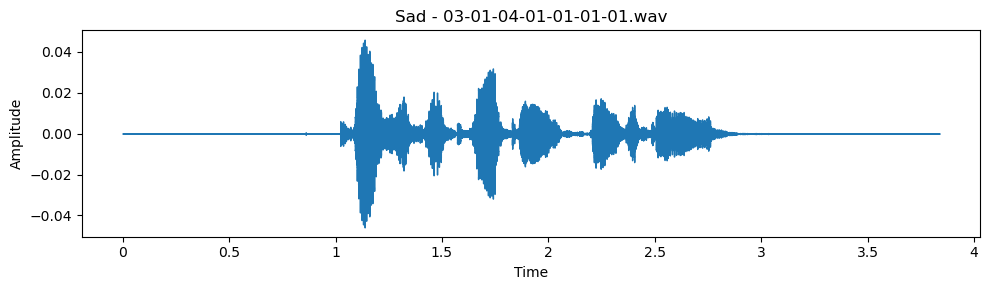

In [33]:
plot_waveform_by_emotion("sad", Audio_speech)

# Model Training Pipeline

## Label encoding

In [40]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Train test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In this step we split our dataset into training and testing sets using `train_test_split`.
I ensured **stratification** to maintain class balance in both sets. Also, random state ensures reproducibility of results.

## Scaling
`StandardScaler`is used to normalize the features. This ensures that all features contribute equally to the model training and prevents features with larger ranges from dominating.

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Classifier

In [43]:
selector_model = RandomForestClassifier(n_estimators=100, random_state=42)
selector_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

### SMOTE 

In [44]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning 

In [45]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=params,
                    cv=3,
                    n_jobs=-1,
                    verbose=1)

grid.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=1)

### Classification Report

Accuracy: 0.6945010183299389
              precision    recall  f1-score   support

       angry       0.79      0.73      0.76        75
        calm       0.79      0.91      0.84        75
     disgust       0.45      0.72      0.55        39
     fearful       0.68      0.63      0.65        75
       happy       0.83      0.57      0.68        75
     neutral       0.70      0.68      0.69        38
         sad       0.72      0.63      0.67        75
   surprised       0.54      0.69      0.61        39

    accuracy                           0.69       491
   macro avg       0.69      0.70      0.68       491
weighted avg       0.71      0.69      0.70       491



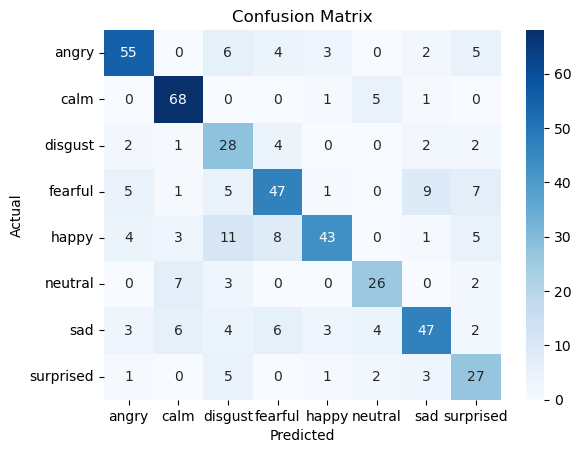

Weighted F1 Score: 0.6965108292214194
Macro F1 Score: 0.6824054052497794


In [46]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Weighted F1-score (accounts for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score:", f1)

# Or, for macro F1-score (equal weight to all classes)
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

## XGBoost Classifier

### Hyperparameter Tuning

In [49]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],   # L1 regularization
    'reg_lambda': [1, 5]     # L2 regularization
}
xgb = XGBClassifier(random_state=42, objective='multi:softmax', num_class=len(np.unique(y_encoded)))


### Model Fitting

In [50]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=25,  
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train_resampled, y_train_resampled)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=8, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 10],
                                        'n_estimators': [100, 200],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [1, 5],
                                        'subsample': [0.8]},
                   random_state=42, scoring='f1_weighted', verbose=1)

### Classification Report

Accuracy: 0.7311608961303462
              precision    recall  f1-score   support

       angry       0.76      0.80      0.78        75
        calm       0.80      0.88      0.84        75
     disgust       0.63      0.69      0.66        39
     fearful       0.68      0.69      0.69        75
       happy       0.81      0.63      0.71        75
     neutral       0.74      0.74      0.74        38
         sad       0.72      0.64      0.68        75
   surprised       0.65      0.79      0.71        39

    accuracy                           0.73       491
   macro avg       0.72      0.73      0.72       491
weighted avg       0.73      0.73      0.73       491



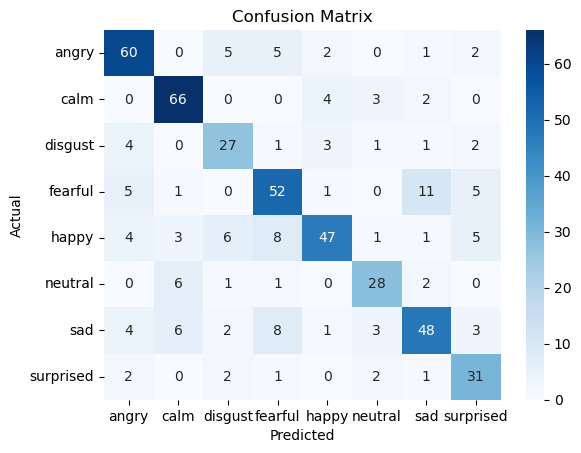

Weighted F1 Score: 0.7298213581426577
Macro F1 Score: 0.724946557049576


In [51]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Weighted F1-score (accounts for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score:", f1)

# Or, for macro F1-score (equal weight to all classes)
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

## Multilayer Perceptron(MLP) Classifier

In [54]:

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    random_state=42,
    verbose=True
)


### Training


In [55]:

mlp.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 1.62407786
Validation score: 0.572614
Iteration 2, loss = 1.07221582
Validation score: 0.651452
Iteration 3, loss = 0.83622777
Validation score: 0.713693
Iteration 4, loss = 0.67364479
Validation score: 0.767635
Iteration 5, loss = 0.56695520
Validation score: 0.800830
Iteration 6, loss = 0.45751590
Validation score: 0.763485
Iteration 7, loss = 0.39351534
Validation score: 0.809129
Iteration 8, loss = 0.32469579
Validation score: 0.809129
Iteration 9, loss = 0.27100043
Validation score: 0.804979
Iteration 10, loss = 0.23061715
Validation score: 0.792531
Iteration 11, loss = 0.17782005
Validation score: 0.829876
Iteration 12, loss = 0.13509343
Validation score: 0.829876
Iteration 13, loss = 0.15686750
Validation score: 0.821577
Iteration 14, loss = 0.12799828
Validation score: 0.829876
Iteration 15, loss = 0.08144190
Validation score: 0.817427
Iteration 16, loss = 0.08563318
Validation score: 0.821577
Iteration 17, loss = 0.05739516
Validation score: 0.858921
Iterat

MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64), learning_rate='adaptive',
              max_iter=500, random_state=42, verbose=True)

### Classification Report

Accuracy: 0.7617107942973523
              precision    recall  f1-score   support

       angry       0.80      0.89      0.84        75
        calm       0.83      0.89      0.86        75
     disgust       0.68      0.64      0.66        39
     fearful       0.73      0.75      0.74        75
       happy       0.73      0.71      0.72        75
     neutral       0.84      0.71      0.77        38
         sad       0.74      0.71      0.72        75
   surprised       0.74      0.67      0.70        39

    accuracy                           0.76       491
   macro avg       0.76      0.75      0.75       491
weighted avg       0.76      0.76      0.76       491



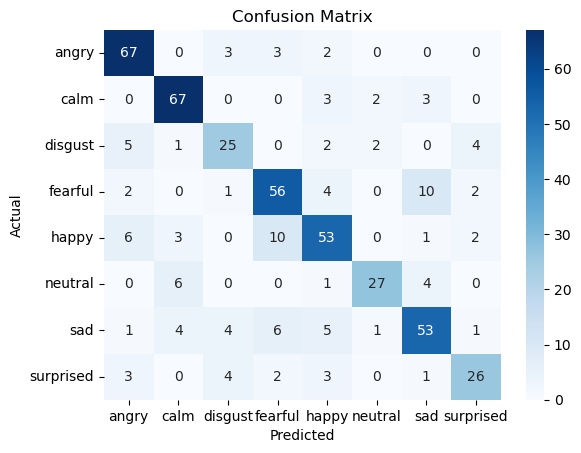

Weighted F1 Score: 0.7598151053226798
Macro F1 Score: 0.7509893027998433


In [56]:
# Predict & evaluate
y_pred = mlp.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
from sklearn.metrics import f1_score

# Weighted F1-score (accounts for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1 Score:", f1)

# Or, for macro F1-score (equal weight to all classes)
f1_macro = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", f1_macro)

# Model Saving

In [62]:
with open("Trained Model/mlp_model.pkl", "wb") as f:
    pickle.dump(mlp, f)

with open("Trained Model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("Trained Model/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

FileNotFoundError: [Errno 2] No such file or directory: 'Trained Model/mlp_model.pkl'